# Proteogenomics database generation using py-pgatk


This notebook presents commands in `py-pgatk` to:
- download data from various sources including ENSEMBL for reference files, COSMIC & cBioPortal for cancer mutations, and gnomAD & ENSEMBL for population variants.
- generate protein databases using the downloaded files or from custom files (mutations in VCF and transcripts in GTF)
- explore the database content (number of proteins and overlaps in tryptic peptides between various protein categories)

`py-pgatk` is implemented in `Python` and is available here: https://github.com/bigbio/py-pgatk. 
The commands are documented here: https://pgatk.readthedocs.io/en/latest/pypgatk.html.
The tools are also builtin to a nextflow workflow: https://nf-co.re/pgdb.

The easiset way to run this notebook is by installing conda and creating an environment for installing the required packages. 


# Part 1: Setup the environment

### Get notebook and data
Updated version can be found here: https://github.com/husensofteng/ProteoWorks/blob/master/workshop_pgdb/pgdb.ipynb


### Install Conda (only up to version 0.0.19)
Download Conda for your operating system and follow the installation instructions from here: https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html#regular-installation

Next, open a terminal window and run the following commands:

### Create `pgdb` environment (only once)
`conda create -n pgdb pypgatk jupyterlab`

### Activate `pgdb` environment (everytime with new terminal/login)
`conda activate pgdb`

### Browse to your working directory and start Jupyter from there using
`jupyter-notebook`



### Download configuration files and related tools

#### Import required libraries

In [1]:
import os
import shutil
import sys
from collections import Counter
import pypgatk
from Bio import SeqIO
import matplotlib.pyplot as plt

#### Get Configuaration Files

In [2]:
if not os.path.isdir('config'):
    os.system('wget https://github.com/bigbio/py-pgatk/archive/refs/tags/v0.0.19.zip')
    os.system('unzip v0.0.19.zip')
    shutil.copytree('py-pgatk-0.0.19/pypgatk/config', 'config')
if os.path.isdir('config'):
    print('the files are available in config/ in the current directory:\n ', os.getcwd())
    try:
        os.rmdir('py-pgatk-*')
    except FileNotFoundError:
        pass

the files are available in config/ in the current directory:
  /Users/husen/Documents/Karolinska Institutet/GRP_LehtioLab_bioinformatics_brains - General/ProteoWorks/workshop_pgdb


### Install gffread v.0.11.7 
This tool is needed to convert GTF (gene-transript annotation file) to FASTA (DNA sequence)

In [3]:
if not os.path.isfile('gffread'):
    if 'linux' in sys.platform:
        os.system('wget https://github.com/gpertea/gffread/releases/download/v0.11.7/gffread-0.11.7.Linux_x86_64.tar.gz')
        os.system('tar -xvzf gffread-0.11.7.Linux_x86_64.tar.gz')
        shutil.move('gffread-0.11.7.Linux_x86_64/gffread', 'gffread')
    elif 'darwin' in sys.platform:
        os.system('wget https://github.com/gpertea/gffread/releases/download/v0.11.7/gffread-0.11.7.OSX_x86_64.tar.gz')
        os.system('tar -xvzf gffread-0.11.7.OSX_x86_64.tar.gz')
        shutil.move('gffread-0.11.7.OSX_x86_64/gffread', 'gffread')
    else:
        print('SORRY: only Linux and MAC are supported, maybe you need to try manually installing gffread')

if os.path.isfile('gffread'):
    print('gffread is ready to be used')
    try:
        os.rmdir('gffread-*')
    except FileNotFoundError:
        pass

gffread is ready to be used


#### Before begining, let's test if pypgatk is working, you should see a help message that lists the existing commands

In [4]:
!pypgatk_cli.py -h

Usage: pypgatk_cli.py [OPTIONS] COMMAND [ARGS]...

  This is the main tool that give access to all commands and options provided
  by the pypgatk

Options:
  -h, --help  Show this message and exit.

Commands:
  cbioportal-downloader    Command to download the the cbioportal studies
  cbioportal-to-proteindb  Command to translate cbioportal mutation data into
                           proteindb
  cosmic-downloader        Command to download the cosmic mutation database
  cosmic-to-proteindb      Command to translate Cosmic mutation data into
                           proteindb
  dnaseq-to-proteindb      Generate peptides based on DNA sequences
  ensembl-check            Command to check ensembl database for stop codons,
                           gaps
  ensembl-downloader       Command to download the ensembl information
  generate-decoy           Create decoy protein sequences using multiple
                           methods DecoyPYrat, Reverse/Shuffled Proteins.
  threeframe-transl

# Part 2: DNA to Protein

In this part we will use the `dnaseq-to-proteindb` command to translate DNA sequences in fasta format to protein. We will also show how to convert a GTF obtained from a reference assembly or from a RNA-seq to DNA sequences and then protein sequence.

## Download relevant files

First we need to specify what files to download from the reference assembly. By default, `ensembl-downloader` downloads all files. The flags below can be used to ignore some files, e.g --skip_dna will skip downloading the reference DNA sequence, etc.

* Note: versions prior to v0.0.20 don't have the feature to download the DNA reference assembly. IF you are using an older version you need to download the DNA fasta manually, uncomment the commands given below to perform this step.

### Check the flags below to know what flags to use.

In [5]:
!pypgatk_cli.py ensembl-downloader -h

Usage: pypgatk_cli.py ensembl-downloader [OPTIONS]

  This tool enables to download from enseml ftp the FASTA and GTF files

Options:
  -c, --config_file TEXT          Configuration file for the ensembl data
                                  downloader pipeline
  -o, --output_directory TEXT     Output directory for the peptide databases
  -fp, --folder_prefix_release TEXT
                                  Output folder prefix to download the data
  -t, --taxonomy TEXT             Taxonomy identifiers (comma separated list
                                  can be given) that will be use to download
                                  the data from Ensembl
  -l, --list_taxonomies           Print the list of all the taxonomies in
                                  ENSEMBL (https://www.ensembl.org)
  -sg, --skip_gtf                 Skip the gtf file during the download
  -sp, --skip_protein             Skip the protein fasta file during download
  -sc, --skip_cds                 Skip the CDS 


#### Get taxonomy ID for the species of interest
However, as shown above we need to specify a taxonomy number in order to get files from a reference assembly for our species of interest. 

Can you find the taxonomy ID for homo sapiens using the following command?

In [ ]:
!pypgatk_cli.py ensembl-downloader -c config/ensembl_downloader_config.yaml -l -sv -sg -sp -sc -sd -sn 

Let's download reference files except VCF (variants) for `Meleagris_gallopavo.Turkey` (taxonomy id: 9103) into a folder named ensembl_files

In [7]:
!pypgatk_cli.py ensembl-downloader -c config/ensembl_downloader_config.yaml -t 9103 -o ensembl_files --skip_vcf

DEBUG:pypgatk.toolbox.general:Files downloaded -- ensembl_files/Meleagris_gallopavo.Turkey_5.1.pep.all.fa,ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.gtf,ensembl_files/Meleagris_gallopavo.Turkey_5.1.cds.all.fa,ensembl_files/Meleagris_gallopavo.Turkey_5.1.cdna.all.fa,ensembl_files/Meleagris_gallopavo.Turkey_5.1.ncrna.fa,ensembl_files/Meleagris_gallopavo.Turkey_5.1.dna_sm.toplevel.fa
INFO:Main Pipeline Ensembl Downloader:Pipeline Finish !!!


Check the contents of the ensembl_files on your computer system, you should see the following files downloaded:

In [8]:
os.listdir('ensembl_files')

['Meleagris_gallopavo.Turkey_5.1.106.gtf',
 'Meleagris_gallopavo.Turkey_5.1.dna_sm.toplevel.fa',
 'Meleagris_gallopavo.Turkey_5.1.pep.all.fa',
 'Meleagris_gallopavo.Turkey_5.1.ncrna.fa',
 'Meleagris_gallopavo.Turkey_5.1.cds.all.fa',
 'Meleagris_gallopavo.Turkey_5.1.cdna.all.fa']

In [9]:
#Sometimes downloading of DNA assembly fails due to its large file size, the following will try to download it if it is not already there.
if not os.path.isfile('ensembl_files/Meleagris_gallopavo.Turkey_5.1.dna_sm.toplevel.fa'):
    !wget http://ftp.ensembl.org/pub/current_fasta/meleagris_gallopavo/dna/Meleagris_gallopavo.Turkey_5.1.dna_sm.toplevel.fa.gz
    !mv Meleagris_gallopavo.Turkey_5.1.dna_sm.toplevel.fa ensembl_files/
    !gunzip ensembl_files/*


#### Convert GTF (can be reference or custom from RNA-seq) to DNA sequences
Although the cdna.fa and ncrna.fa files can be used as reference DNA, but we wull use  GTF since it provides more flexibility to select desired transcript types. Also, when running your own RNA-seq experiments you usually get a GTF file as a final output therefore it is better to learn how to translate transcripts starting from a GTF file.

However, since the `dnaseq-to-proteindb` tool only accepts FASTA files as input, we first need to convert the GTF into FASTA using gffread that is a separate tool.


In [10]:
!gffread -F -w ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa -g ensembl_files/Meleagris_gallopavo.Turkey_5.1.dna_sm.toplevel.fa ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.gtf



FASTA index file ensembl_files/Meleagris_gallopavo.Turkey_5.1.dna_sm.toplevel.fa.fai created.


Now that we have the DNA fasta file ready to be used, let's take a look at the parameters that can be used:

In [11]:
!pypgatk_cli.py dnaseq-to-proteindb  -h

Usage: pypgatk_cli.py dnaseq-to-proteindb [OPTIONS]

Options:
  -c, --config_file TEXT         Configuration to perform conversion between
                                 ENSEMBL Files
  --input_fasta TEXT             Path to sequences fasta
  --translation_table INTEGER    Translation Table (default 1)
  --num_orfs INTEGER             Number of ORFs (default 0)
  --num_orfs_complement INTEGER  Number of ORFs from the reverse side (default
                                 0)
  --output_proteindb TEXT        Output file name, exits if already exists
  -p, --var_prefix TEXT          String to add before the variant peptides
  --skip_including_all_cds       By default any transcript that has a defined
                                 CDS will be translated, this option disables
                                 this features instead it only depends on the
                                 biotypes
  --include_biotypes TEXT        Include Biotypes

  --biotype_str TEXT             String us

#### Generate a protein database from lncRNAs only
*Use the include_biotypes flag to specify what kind of transcripts should be translated. See ensembl biotypes: http://www.ensembl.org/info/genome/genebuild/biotypes.html

In [ ]:
!pypgatk_cli.py dnaseq-to-proteindb --config_file config/ensembl_config.yaml --input_fasta ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa --output_proteindb lncRNAs.fa --skip_including_all_cds --var_prefix lncRNA_ --include_biotypes lncRNA


In [53]:
print("\nGenerated:", Counter([x.split('_')[0] for x in list(SeqIO.index('lncRNAs.fa', "fasta").keys())]).items())



Generated: dict_items([('lncRNA', 5109)])


#### Generate protein database from other non-coding RNAs

In [ ]:
!pypgatk_cli.py dnaseq-to-proteindb --config_file config/ensembl_config.yaml --input_fasta ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa --output_proteindb ncRNAs.fa --skip_including_all_cds --var_prefix ncRNA_ --include_biotypes miRNA,miscRNA,piRNA,rRNA,siRNA,snRNA,snoRNA,tRNA,vaultRNA


In [54]:
print("\nGenerated:", Counter([x.split('_')[0] for x in list(SeqIO.index('ncRNAs.fa', "fasta").keys())]).items())



Generated: dict_items([('ncRNA', 1500)])


#### Generate protein database from alternative reading frames of coding sequences

In [ ]:
!pypgatk_cli.py dnaseq-to-proteindb --config_file config/ensembl_config.yaml --input_fasta ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa --output_proteindb altORFs.fa --skip_including_all_cds --var_prefix altORF_ --include_biotypes altORFs


In [55]:
print("\nGenerated:", Counter([x.split('_')[0] for x in list(SeqIO.index('altORFs.fa', "fasta").keys())]).items())



Generated: dict_items([('altORF', 84885)])


#### Generate a protein database from pseudogenes? 

In [ ]:
#write your code here
!pypgatk_cli.py dnaseq-to-proteindb --config_file config/ensembl_config.yaml --input_fasta ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa --output_proteindb pesuedogenes.fa --skip_including_all_cds --var_prefix pesuedogene_ --include_biotypes pseudogene,processed_pseudogene


In [56]:
print("\nGenerated:", Counter([x.split('_')[0] for x in list(SeqIO.index('pesuedogenes.fa', "fasta").keys())]).items())



Generated: dict_items([('pesuedogene', 477)])


### Concatenate the generated protein databases with reference proteome

In [16]:
!cat lncRNAs.fa pesuedogenes.fa ncRNAs.fa altORFs.fa ensembl_files/Meleagris_gallopavo.Turkey_5.1.pep.all.fa > proteins.fa

Counter([x.replace('ENS','Can_ENS').split('_')[0] for x in list(SeqIO.index('proteins.fa', "fasta").keys())]).items()


dict_items([('lncRNA', 5109), ('pesuedogene', 477), ('ncRNA', 1500), ('altORF', 84885), ('Can', 28295)])

#### Perform six-frame translation on DNA seqyence

In [ ]:
!pypgatk_cli.py dnaseq-to-proteindb --config_file config/ensembl_config.yaml --skip_including_all_cds --input_fasta ensembl_files/Meleagris_gallopavo.Turkey_5.1.106.fa --output_proteindb sixframes.fa --var_prefix sixframe_  --num_orfs 3 --num_orfs_complement 3 --include_biotypes all


In [57]:
print("\nGenerated:", Counter([x.split('_')[0] for x in list(SeqIO.index('sixframes.fa', "fasta").keys())]).items())



Generated: dict_items([('sixframe', 184248)])


In [18]:
#function to digest proteins

def trypsin_digestion(proseq_incl_stop, miss_cleavage=0):
    "digest peptides using the tryptic rule, allowing for miss cleavages"
    all_peptides = []
    for protseq in proseq_incl_stop.split('*'):
        if len(protseq)<=0:
            continue
        peptides = []
        peptide = ''
        "remove the first K/R if in the begining of a reading frame"
        protseq_updated = protseq[0::]
        if protseq[0]=='K' or protseq[0]=='R' and len(protseq)>1:
            protseq_updated = protseq[1::]

        for c, aa in enumerate(protseq_updated):
            peptide += aa
            next_aa = ''
            try:
                next_aa = protseq_updated[c + 1]
            except IndexError:
                pass

            if aa in ['K', 'R'] and next_aa != 'P':  # for trypsin peptides
                if len(peptide) > 0:
                    peptides.append(peptide)
                peptide = ''
                continue

        if len(peptide) > 0:
            peptides.append(peptide)

        peptides_with_miss_cleavage = []
        for i in range(1, miss_cleavage + 1):
            for j, pep in enumerate(peptides):
                if j + i < len(peptides):
                    peptide = ''.join([x for x in (peptides[j:j + i + 1])])
                    peptides_with_miss_cleavage.append(peptide)

        peptides.extend(peptides_with_miss_cleavage)
        all_peptides.extend(peptides)

    return all_peptides

#### Investigate the overlap between tryptic peptides from various categories!

In [19]:
#Specify protein files to use
prot_files = ['proteins.fa']#, 'sixframes.fa']

proteins = {}
for prot_file in prot_files:
    for record in SeqIO.parse(prot_file, 'fasta'):
        prot_type = str(record.id).replace('ENS', 'Can_ENS').split('_')[0]
        try:
            proteins[prot_type].extend(trypsin_digestion(str(record.seq)))
        except KeyError:
            proteins[prot_type] = trypsin_digestion(str(record.seq))

#unify
for prot_type in proteins.keys():
    proteins[prot_type] = set(proteins[prot_type])

print('Number of tryptic peptides per type:\n', '\n'.join([k+' = '+str(len(items)) for k,items in proteins.items()]))

Number of tryptic peptides per type:
 lncRNA = 170307
pesuedogene = 32431
ncRNA = 4565
altORF = 2075045
Can = 525753


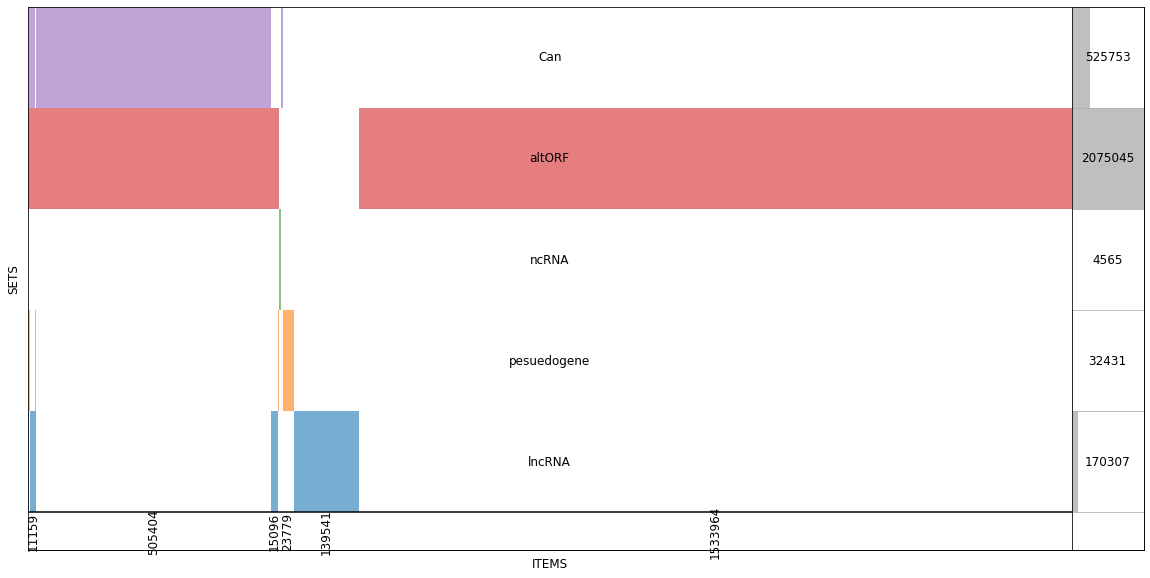

In [20]:
###Optional
#make a supervenn to plot the overlaps (takes some time)
try:
    from supervenn import supervenn
except ModuleNotFoundError:
    !pip install supervenn #does not work for some reason it looks at the base env for this package (print(sys.executable) )


labels = list(proteins.keys())
sets = [proteins[x] for x in proteins.keys()]

plt.figure(figsize=(20, 10))
supervenn(sets, labels, min_width_for_annotation=10000, rotate_col_annotations=True, 
          side_plots='right', chunks_ordering='occurrence', alternating_background= False)
plt.grid(False)
plt.savefig('baroverlap.svg')

#### Can you also show peptides from the six-frame translation? can you speculate how they would look like?

# Part 3: DNA Variants to Proteins


In this part we will use the `vcf-to-proteindb` command to translate mutations in VCF format to proteins. The output of genome/exome sequencing is usually a VCF file that includes the list of identified mutations.


## Download relevant files

Lets download a `VCF` file from `ENSEMBL` containing all `SNP`s from homo sapiens, to minimize computational time we only download SNPs identified in `chrY`. 

The idea is to learn how to convert a `VCF` file and you can replace this `VCF` with any standard `VCF` file that is generated from WGS/WES. 

In [21]:
!wget http://ftp.ensembl.org/pub/release-106/variation/vcf/homo_sapiens/homo_sapiens_incl_consequences-chrY.vcf.gz
!gunzip homo_sapiens_incl_consequences-chrY.vcf.gz

--2022-06-08 11:44:59--  http://ftp.ensembl.org/pub/release-106/variation/vcf/homo_sapiens/homo_sapiens_incl_consequences-chrY.vcf.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.139
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31480732 (30M) [application/x-gzip]
Saving to: ‘homo_sapiens_incl_consequences-chrY.vcf.gz’

homo_sapiens_incl_c 100%[===================>]  30,02M  1,09MB/s    in 29s     

2022-06-08 11:45:29 (1,03 MB/s) - ‘homo_sapiens_incl_consequences-chrY.vcf.gz’ saved [31480732/31480732]



Also, we need to download transcript structures and sequences for homo sapiens, run the following to download `GTF` and `cdna` files

In [22]:
!pypgatk_cli.py ensembl-downloader -c config/ensembl_downloader_config.yaml -t 9606 -o ensembl_files --skip_vcf --skip_protein --skip_ncrna --skip_dna --skip_cdna


DEBUG:pypgatk.toolbox.general:Files downloaded -- ensembl_files/Homo_sapiens.GRCh38.106.gtf,ensembl_files/Homo_sapiens.GRCh38.cds.all.fa
INFO:Main Pipeline Ensembl Downloader:Pipeline Finish !!!


#### Check the flags that can be used for a VCF file

In [23]:
!pypgatk_cli.py vcf-to-proteindb -h

Usage: pypgatk_cli.py vcf-to-proteindb [OPTIONS]

Options:
  -c, --config_file TEXT          Configuration to perform conversion between
                                  ENSEMBL Files
  -f, --input_fasta TEXT          Path to the transcript sequence
  -v, --vcf TEXT                  Path to the VCF file
  -g, --gene_annotations_gtf TEXT
                                  Path to the gene annotations file
  -t, --translation_table INTEGER
                                  Translation table (Default 1)
  -m, --mito_translation_table INTEGER
                                  Mito_trans_table (default 2)
  -p, --var_prefix TEXT           String to add before the variant peptides
  --report_ref_seq                In addition to var peps, also report all ref
                                  peps
  -o, --output_proteindb TEXT     Output file name, exits if already exists
  --annotation_field_name TEXT    Annotation field name found in the INFO
                                  column, e.g CS

#### Convert the variants to protein sequences


The first time you run the command, it takes a bit long because it converts the `GTF` file to an `sqlite` database

In [24]:
!pypgatk_cli.py vcf-to-proteindb -c config/ensembl_config.yaml --input_fasta ensembl_files/Homo_sapiens.GRCh38.cds.all.fa --vcf homo_sapiens_incl_consequences-chrY.vcf --gene_annotations_gtf ensembl_files/Homo_sapiens.GRCh38.106.gtf --output_proteindb chrY_protein_variants.fa

print('Generated {} variant proteins from {} variants'.format(
    Counter([x.split('_')[0] for x in list(SeqIO.index('chrY_protein_variants.fa', "fasta").keys())]).items(),
    len(set(['_'.join(x.split('_')[0:3]) for x in SeqIO.index('chrY_protein_variants.fa', "fasta").keys()]))))


2022-06-08 11:53:24,874 - INFO - Committing changes: 3279000 features
2022-06-08 11:53:25,679 - INFO - Populating features table and first-order relations: 3279404 features
2022-06-08 11:53:25,679 - INFO - Creating relations(parent) index
2022-06-08 11:53:29,309 - INFO - Creating relations(child) index
2022-06-08 11:53:32,918 - INFO - Creating features(featuretype) index
2022-06-08 11:53:35,011 - INFO - Creating features (seqid, start, end) index
2022-06-08 11:53:37,770 - INFO - Creating features (seqid, start, end, strand) index
2022-06-08 11:53:40,749 - INFO - Running ANALYZE features
/Users/husen/opt/anaconda3/envs/pgdbtest1/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
Generated dict_items([('var', 28353)]) variant proteins from 4479 variants


#### Filter variants by allele frequency and consequence 

Depending on the VCF file, you may also need to specify which field name indicates allele frequency using the `-- af_field` parameter.

Below, we only variants that are common in the population (MAF>=0.01).

In [25]:
!pypgatk_cli.py vcf-to-proteindb -c config/ensembl_config.yaml --input_fasta ensembl_files/Homo_sapiens.GRCh38.cds.all.fa --vcf homo_sapiens_incl_consequences-chrY.vcf --gene_annotations_gtf ensembl_files/Homo_sapiens.GRCh38.106.gtf --output_proteindb chrY_protein_variants_VAF05.fa --af_field 'MAF' --af_threshold 0.01

print('Generated {} variant proteins from {} variants'.format(
    Counter([x.split('_')[0] for x in list(SeqIO.index('chrY_protein_variants_VAF05.fa', "fasta").keys())]).items(),
    len(set(['_'.join(x.split('_')[0:3]) for x in SeqIO.index('chrY_protein_variants_VAF05.fa', "fasta").keys()]))))


Databae already existstable features already exists ensembl_files/Homo_sapiens.GRCh38.106.db
Generated dict_items([('var', 28353)]) variant proteins from 0 variants


Filter by consequence, only translate frameshift variants

In [26]:
!pypgatk_cli.py vcf-to-proteindb -c config/ensembl_config.yaml --input_fasta ensembl_files/Homo_sapiens.GRCh38.cds.all.fa --vcf homo_sapiens_incl_consequences-chrY.vcf --gene_annotations_gtf ensembl_files/Homo_sapiens.GRCh38.106.gtf --output_proteindb chrY_protein_variants_framshift.fa --include_consequences 'frameshift_variant'

print('Generated {} variant proteins from {} variants'.format(
    Counter([x.split('_')[0] for x in list(SeqIO.index('chrY_protein_variants_framshift.fa', "fasta").keys())]).items(),
    len(set(['_'.join(x.split('_')[0:3]) for x in SeqIO.index('chrY_protein_variants_framshift.fa', "fasta").keys()]))))


Databae already existstable features already exists ensembl_files/Homo_sapiens.GRCh38.106.db
/Users/husen/opt/anaconda3/envs/pgdbtest1/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
Generated dict_items([('var', 28353)]) variant proteins from 96 variants


### * Note on translating patient sequencing data
The same command as above can be applied to generate a protein database per patient.

Provide path of the VCF file that you obtain from `WGS`/`WES`. 

If you also have `RNA-seq` from the same patient, you can convert the `GTF` file to `fasta` using the gffread command shown in the second part of this notebook. This enables translation of expressed transcripts only.

For cases where no `RNA-seq` is perfromed, you can still give the refernce GTF file and the canonical transcripts will be used to generate mutated/variant proteins

# Part 4a: Mutations to Proteins (cBioPortal)


In this part we will use the `cbioportal-downloader` and `cbioportal-to-proteindb` command to translate mutations from cancer studies in cBioPortal (https://www.cbioportal.org/).


First we need to specify what study to download from cBioPortal (see -l flag): 



Check the flags below to know what flags to use.

In [27]:
!pypgatk_cli.py cbioportal-downloader -h

Usage: pypgatk_cli.py cbioportal-downloader [OPTIONS]

Options:
  -c, --config_file TEXT       Configuration file for the ensembl data
                               downloader pipeline
  -o, --output_directory TEXT  Output directory for the peptide databases
  -l, --list_studies           Print the list of all the studies in cBioPortal
                               (https://www.cbioportal.org)
  -d, --download_study TEXT    Download a specific Study from cBioPortal --
                               (all to download all studies)
  -th, --multithreading        Enable multithreading to download multiple
                               files ad the same time
  -h, --help                   Show this message and exit.


#### Download data for study ID blca_mskcc_solit_2014

In addition to the files from cBioPortal we also need to download coding sequences from GRCh37, the matching genome assemblies.

In [28]:
study_id = 'blca_mskcc_solit_2014'
!pypgatk_cli.py cbioportal-downloader -c config/cbioportal_config.yaml -d $study_id -o ./
!tar -xzvf $study_id".tar"

#Download linking CDSs (the mutations are aligned to hg37)
!wget ftp://ftp.ensembl.org/pub/release-75/fasta/homo_sapiens/cds/Homo_sapiens.GRCh37.75.cds.all.fa.gz
!gunzip *.gz

DEBUG:pypgatk.toolbox.general:The following study 'blca_mskcc_solit_2014' has been downloaded. 
x blca_mskcc_solit_2014/
x blca_mskcc_solit_2014/meta_mutations.txt
x blca_mskcc_solit_2014/data_log2_cna.txt
x blca_mskcc_solit_2014/Readme.txt
x blca_mskcc_solit_2014/meta_clinical_sample.txt
x blca_mskcc_solit_2014/data_cna.txt
x blca_mskcc_solit_2014/case_lists/
x blca_mskcc_solit_2014/case_lists/cases_sequenced.txt
x blca_mskcc_solit_2014/case_lists/cases_all.txt
x blca_mskcc_solit_2014/case_lists/cases_cnaseq.txt
x blca_mskcc_solit_2014/case_lists/cases_log2CNA.txt
x blca_mskcc_solit_2014/case_lists/cases_cna.txt
x blca_mskcc_solit_2014/data_clinical_patient.txt
x blca_mskcc_solit_2014/data_clinical_sample.txt
x blca_mskcc_solit_2014/meta_cna.txt
x blca_mskcc_solit_2014/data_cna_hg19.seg
x blca_mskcc_solit_2014/data_gene_panel_matrix.txt
x blca_mskcc_solit_2014/meta_clinical_patient.txt
x blca_mskcc_solit_2014/meta_study.txt
x blca_mskcc_solit_2014/LICENSE
x blca_mskcc_solit_2014/data_

The files are downloaded into a directory with the same name as the study ID. It contains several files but we only need the following two files:
- `data_clinical_sample.txt`: 

    This file contains metada or clinical information about each of the samples in the study
    
    
- `data_mutations.txt` (it might have slightly different names depending on the cBioPortal version): 

    This file contains the list of mutations identified in this study


#### Translate the downloaded set of mutations

First check what options you have!

In [29]:
!pypgatk_cli.py cbioportal-to-proteindb -h

Usage: pypgatk_cli.py cbioportal-to-proteindb [OPTIONS]

Options:
  -c, --config_file TEXT          Configuration for cbioportal to proteindb
                                  tool
  -in, --input_mutation TEXT      Cbioportal mutation file
  -fa, --input_cds TEXT           CDS genes from ENSEMBL database
  -out, --output_db TEXT          Protein database including all the mutations
  -f, --filter_column TEXT        Column in the VCF file to be used for
                                  filtering or splitting mutations
  -a, --accepted_values TEXT      Limit mutations to values (tissue type,
                                  sample name, etc) considered for generating
                                  proteinDBs, by default mutations from all
                                  records are considered
  -s, --split_by_filter_column    Use this flag to generate a proteinDB per
                                  group as specified in the filter_column,
                                  defaul

In [30]:

!pypgatk_cli.py cbioportal-to-proteindb --config_file config/cbioportal_config.yaml --input_cds Homo_sapiens.GRCh37.75.cds.all.fa --input_mutation $study_id/data_mutations.txt --clinical_sample_file blca_mskcc_solit_2014/data_clinical_sample.txt --output_db variants_proteindb.fa

print('Generated {} variant proteins from {} variants'.format(
    Counter([str(x.id).split(':')[0] for x in SeqIO.parse('variants_proteindb.fa', "fasta")]),
    len(set([x.id for x in SeqIO.parse('variants_proteindb.fa', "fasta")]))
    ))



/Users/husen/opt/anaconda3/envs/pgdbtest1/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
Generated Counter({'cbiomut': 1125}) variant proteins from 1057 variants


Optionally, you can filter the samples based on any of the columns in the data_clinical_sample.txt. First, let's see what fields (clinical information) is available for the samples in this study:

In [31]:
[x.strip() for x in open('{}/data_clinical_sample.txt'.format(study_id)).readline().split('\t')]

['#Patient Identifier',
 'Sample Identifier',
 'Sample Type',
 'Concomitant Carcinoma in situ',
 'Lymph Node Status',
 'Tissue Sequenced',
 'Oncotree Code',
 'Cancer Type',
 'Cancer Type Detailed',
 'Somatic Status',
 'TMB (nonsynonymous)']

Let's only use mutations from samples that have their `Lymph Node Status` as `Positive`. Cancer Type can also be used to filter mutations for a specific cancer type.

In [32]:

!pypgatk_cli.py cbioportal-to-proteindb --config_file config/cbioportal_config.yaml --input_cds Homo_sapiens.GRCh37.75.cds.all.fa --input_mutation $study_id/data_mutations.txt --clinical_sample_file blca_mskcc_solit_2014/data_clinical_sample.txt --output_db variants_proteindb_filtered.fa --filter_column 'LYMPH_NODE_STATUS' --accepted_values 'Positive'

print('Generated {} variant proteins from {} variants'.format(
    Counter([str(x.id).split(':')[0] for x in SeqIO.parse('variants_proteindb_filtered.fa', "fasta")]),
    len(set([x.id for x in SeqIO.parse('variants_proteindb_filtered.fa', "fasta")]))
    ))


sample_groups_dict blca_mskcc_solit_2014/data_clinical_sample.txt LYMPH_NODE_STATUS
No clinical info was found for sample Tumor_Sample_Barcode. Skipping (line 0): Hugo_Symbol	Entrez_Gene_Id	Center	NCBI_Build	Chromosome	Start_Position	End_Position	Strand	Consequence	Variant_Classification	Variant_Type	Reference_Allele	Tumor_Seq_Allele1	Tumor_Seq_Allele2	dbSNP_RS	dbSNP_Val_Status	Tumor_Sample_Barcode	Matched_Norm_Sample_Barcode	Match_Norm_Seq_Allele1	Match_Norm_Seq_Allele2	Tumor_Validation_Allele1	Tumor_Validation_Allele2	Match_Norm_Validation_Allele1	Match_Norm_Validation_Allele2	Verification_Status	Validation_Status	Mutation_Status	Sequencing_Phase	Sequence_Source	Validation_Method	Score	BAM_File	Sequencer	t_ref_count	t_alt_count	n_ref_count	n_alt_count	HGVSc	HGVSp	HGVSp_Short	Transcript_ID	RefSeq	Protein_position	Codons	Hotspot

/Users/husen/opt/anaconda3/envs/pgdbtest1/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three.

# Part 4b: Mutations to Proteins (COSMIC)


In this part we will use the `cosmic-downloader` and `cosmic-to-proteindb` command to translate cancer mutations from COSMIC. The downloader downloads the following files:

- `CosmicMutantExport.tsv`  : `tsv` file containing somatic mutations from human samples
-  `CosmicCLP_MutantExport.tsv` : `tsv` file containing somatic mutations from cancer cell lines
- `All_COSMIC_Genes.fasta`: Transcripts `fasta` file, it is used to extract sequences of altered transcripts.

However, since COSMIC requires registeration and the file sizes are large (15G), the download takes some time therefore I have pre-downloaded the files and extracted 50k mutations from it as a sample to make the processes run faster. Run the following code to download a sample directory

In [47]:
if not os.path.isfile('cosmic_files.tar.gz'):
    !wget https://github.com/husensofteng/ProteoWorks/raw/master/workshop_pgdb/cosmic_files.tar.gz
    !tar -xzvf cosmic_files.tar.gz


--2022-06-08 12:36:05--  https://github.com/husensofteng/ProteoWorks/raw/master/workshop_pgdb/cosmic_files.tar.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/husensofteng/ProteoWorks/master/workshop_pgdb/cosmic_files.tar.gz [following]
--2022-06-08 12:36:05--  https://raw.githubusercontent.com/husensofteng/ProteoWorks/master/workshop_pgdb/cosmic_files.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38247627 (36M) [application/octet-stream]
Saving to: ‘cosmic_files.tar.gz’

cosmic_files.tar.gz 100%[===================>]  36,48M  11,0MB/s    in 3,4s    

2022-06-08 12:36

### For actual analysis:
- remove the sample `cosmic_files` directory
- register an account on: https://cancer.sanger.ac.uk/
- replace `yourUserName` and `yourPassword` in the follwing command with your actual credentials from your account in COSMIC. 
- run the following command to download the mutation data files from COSMIC and ponder on some simple childhood memories until the files are downloaded :)

In [48]:
if not os.path.isdir('cosmic_files'):
    !pypgatk_cli.py cosmic-downloader -u yourUserName -p yourPassword -c config/cosmic_config.yaml -o cosmic_files/


In [40]:
!pypgatk_cli.py cosmic-to-proteindb -h


Usage: pypgatk_cli.py cosmic-to-proteindb [OPTIONS]

Options:
  -c, --config_file TEXT        Configuration file for the cosmic data
                                pipelines
  -in, --input_mutation TEXT    Cosmic Mutation data file
  -fa, --input_genes TEXT       All Cosmic genes
  -out, --output_db TEXT        Protein database including all the mutations
  -f, --filter_column TEXT      Column in the VCF file to be used for
                                filtering or splitting mutations
  -a, --accepted_values TEXT    Limit mutations to values (tissue type, sample
                                name, etc) considered for generating
                                proteinDBs, by default mutations from all
                                records are considered
  -s, --split_by_filter_column  Use this flag to generate a proteinDB per
                                group as specified in the filter_column,
                                default is False
  -h, --help                    S

### Translate cosmic mutations
To translate all mutations, we just need to specify paths for the mutations file and the transcripts file. 

In [49]:

!pypgatk_cli.py cosmic-to-proteindb -c config/cosmic_config.yaml -in cosmic_files/CosmicMutantExport.tsv -fa cosmic_files/All_COSMIC_Genes.fasta -out cosmic_proteinDB.fa



/Users/husen/opt/anaconda3/envs/pgdbtest1/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Since the actual `CosmicMutantExport.tsv` file contains around 50 Million mutations, we needs to filter them according to our needs otherwise the resulting protein database becomes too large. 

As shown in the help message, the `cosmic-to-proteindb` provides a `--filter_column` parameter that can be used to select any column for filtering and then with the `--accepted_values` parameter we can list the desired values. 

Inspect the following features to identify a column that you want to use as a filter:

In [50]:
fields = '\n'.join(open('cosmic_files/CosmicMutantExport.tsv').readline().strip().split('\t'))
print('Columns that can be used to filter mutations:', fields)


Columns that can be used to filter mutations: Gene name
Accession Number
Gene CDS length
HGNC ID
Sample name
ID_sample
ID_tumour
Primary site
Site subtype 1
Site subtype 2
Site subtype 3
Primary histology
Histology subtype 1
Histology subtype 2
Histology subtype 3
Genome-wide screen
GENOMIC_MUTATION_ID
LEGACY_MUTATION_ID
MUTATION_ID
Mutation CDS
Mutation AA
Mutation Description
Mutation zygosity
LOH
GRCh
Mutation genome position
Mutation strand
Resistance Mutation
Mutation somatic status
Pubmed_PMID
ID_STUDY
Sample Type
Tumour origin
Age
HGVSP
HGVSC
HGVSG


Lets use `Primary site` as the filter column and accept mutations from tumors in liver, lung or skin

In [51]:
!pypgatk_cli.py cosmic-to-proteindb -c config/cosmic_config.yaml -in cosmic_files/CosmicMutantExport.tsv -fa cosmic_files/All_COSMIC_Genes.fasta -out cosmic_proteinDB_filtered.fa --filter_column 'Primary site' --accepted_values 'liver,lung,skin'

print('Generated {} variant proteins from {} variants'.format(
    Counter([str(x.id).split(':')[0] for x in SeqIO.parse('cosmic_proteinDB_filtered.fa', "fasta")]),
    len(set([':'.join(str(x.id).split(':')[2::]) for x in SeqIO.parse('cosmic_proteinDB_filtered.fa', "fasta")]))
    ))



/Users/husen/opt/anaconda3/envs/pgdbtest1/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
Generated Counter({'COSMIC': 5163}) variant proteins from 4900 variants


We could also generate mutated proteins of a particular gene, e.g. `CDH6`. If you open the mutations file with a text editor, the gene names can be seen in the first column.

In [52]:
!pypgatk_cli.py cosmic-to-proteindb -c config/cosmic_config.yaml -in cosmic_files/CosmicMutantExport.tsv -fa cosmic_files/All_COSMIC_Genes.fasta -out cosmic_proteinDB_filtered_gene.fa --filter_column 'Gene name' --accepted_values 'CDH6'

print('Generated {} variant proteins from {} variants'.format(
    Counter([str(x.id).split(':')[0] for x in SeqIO.parse('cosmic_proteinDB_filtered_gene.fa', "fasta")]),
    len(set([':'.join(str(x.id).split(':')[2::]) for x in SeqIO.parse('cosmic_proteinDB_filtered_gene.fa', "fasta")]))
    ))



/Users/husen/opt/anaconda3/envs/pgdbtest1/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
Generated Counter({'COSMIC': 454}) variant proteins from 454 variants
